In [1]:
import os
import torch
import numpy as np
from tqdm import tqdm
from utils import Classification_Model, Standard_DataLoader, Trainer, load_rgb_mean_std

In [2]:
CWD = os.getcwd()
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE_NAME = torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'

print(f"CWD: {CWD}")
print(f"DEVICE: {DEVICE_NAME}")

CWD: /mnt/e/xAI-WriterIdentification/HI-EXP/classifier_NN
DEVICE: NVIDIA GeForce RTX 3060


In [3]:
MODEL_PATH = CWD + "/cp/Test_3_TL_val_best_model.pth"
TEST_ID = "VatLat653-0003"
DATASET_DIR = CWD + f"/tests/{TEST_ID}"
OUTPUT_DIR = CWD + f"/tests/{TEST_ID}/output"
SOURCE_DATA_DIR = CWD + "/../../datasets/Vat.lat.653"

if not os.path.exists(DATASET_DIR):
    os.mkdir(DATASET_DIR)
    os.mkdir(DATASET_DIR + "/train")
    os.mkdir(DATASET_DIR + "/val")
    os.mkdir(DATASET_DIR + "/test")

if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

# Phase 1 -> Dataset Splitting

In [4]:
classes = os.listdir(SOURCE_DATA_DIR)
# class "0" -> 42 istanze: 30 train, 6 val, 6 test
# class "1" -> 58 istanze: 45 train, 6 val, 7 test
# class "2" -> 202 istanze: 150 train, 30 val, 22 test
# class "3" -> 220 istanze: 150 train, 30 val, 40 test

for c in classes:
    if not os.path.exists(DATASET_DIR + "/train/" + c):
        os.mkdir(DATASET_DIR + "/train/" + c)
    if not os.path.exists(DATASET_DIR + "/val/" + c):
        os.mkdir(DATASET_DIR + "/val/" + c)
    if not os.path.exists(DATASET_DIR + "/test/" + c):
        os.mkdir(DATASET_DIR + "/test/" + c)

In [5]:
for c in classes:
    instances = os.listdir(SOURCE_DATA_DIR + "/" + c)
    np.random.shuffle(instances)
    
    match c:
        case "0":
            train, val, test = instances[:30], instances[30:36], instances[36:]
        case "1":
            train, val, test = instances[:45], instances[45:51], instances[51:]
        case "2":
            train, val, test = instances[:150], instances[150:180], instances[180:]
        case "3":
            train, val, test = instances[:150], instances[150:180], instances[180:]
    
    for instance in train:
        os.system(f"cp {SOURCE_DATA_DIR}/{c}/{instance} {DATASET_DIR}/train/{c}/{instance}")
    
    for instance in val:
        os.system(f"cp {SOURCE_DATA_DIR}/{c}/{instance} {DATASET_DIR}/val/{c}/{instance}")
    
    for instance in test:
        os.system(f"cp {SOURCE_DATA_DIR}/{c}/{instance} {DATASET_DIR}/test/{c}/{instance}")

In [6]:
for c in classes:
    train_instances = os.listdir(DATASET_DIR + "/train/" + c)
    match c:
        case "0":
            for img in train_instances:
                for i in range(0, 14):
                    os.system(f"cp {DATASET_DIR}/train/{c}/{img} {DATASET_DIR}/train/{c}/{img[:-4]}_cp{i+1}.png")
        case "1":
            for img in train_instances:
                for i in range(0, 9):
                    os.system(f"cp {DATASET_DIR}/train/{c}/{img} {DATASET_DIR}/train/{c}/{img[:-4]}_cp{i+1}.png")
        case "2":
            for img in train_instances:
                for i in range(0, 2):
                    os.system(f"cp {DATASET_DIR}/train/{c}/{img} {DATASET_DIR}/train/{c}/{img[:-4]}_cp{i+1}.png")
        case "3":
            for img in train_instances:
                for i in range(0, 2):
                    os.system(f"cp {DATASET_DIR}/train/{c}/{img} {DATASET_DIR}/train/{c}/{img[:-4]}_cp{i+1}.png")
    
for c in classes:
    val_instances = os.listdir(DATASET_DIR + "/val/" + c)
    for img in val_instances:
        for i in range(0, 3):
            os.system(f"cp {DATASET_DIR}/val/{c}/{img} {DATASET_DIR}/val/{c}/{img[:-4]}_cp{i+1}.png")                

In [7]:
for c in classes:
    print(f"Class {c} -> Train Instances: {len(os.listdir(DATASET_DIR + '/train/' + c))}")

Class 0 -> Train Instances: 450
Class 1 -> Train Instances: 450
Class 2 -> Train Instances: 450
Class 3 -> Train Instances: 450


# Phase 2 -> System Fine-Tuning

In [8]:
num_classes = len(os.listdir(DATASET_DIR + "/test"))
model = Classification_Model(num_classes=num_classes, mode='frozen', cp_path=MODEL_PATH)
model = model.to(DEVICE)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of classes: {num_classes}")
print(f'Number of trainable parameters: {pytorch_total_params}')

Number of classes: 4
Number of trainable parameters: 32996


In [9]:
mean_, std_ = load_rgb_mean_std(f"{DATASET_DIR}/train")
# mean_, std_ = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
train_ds = Standard_DataLoader(directory=f"{DATASET_DIR}/train", batch_size=64, weighted_sampling=True, phase='train', mean=mean_, std=std_, shuffle=True)
val_ds = Standard_DataLoader(directory=f"{DATASET_DIR}/val", batch_size=64, weighted_sampling=False, phase='val', mean=mean_, std=std_, shuffle=False)
tds, t_dl = train_ds.load_data()
vds, v_dl = val_ds.load_data()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1800/1800 [01:57<00:00, 15.29it/s]


In [10]:
os.mkdir(f"{OUTPUT_DIR}/checkpoints")
torch.backends.cudnn.benchmark = True
trainer = Trainer(model=model, t_set=t_dl, v_set=v_dl, DEVICE=DEVICE, optim_type='adam', lr_=0.03, 
                  model_path=OUTPUT_DIR, history_path=OUTPUT_DIR, test_ID=TEST_ID, num_epochs=100)
trainer()

Epoch 1 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:10<00:00,  2.42s/it]


train_loss: 0.5225869260893927 - train_accuracy: 0.8222222222222222



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.04s/it]


val_loss: 4.335880809360081 - val_accuracy: 0.4236111111111111

Epoch 2 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.31s/it]


train_loss: 0.2433329901430342 - train_accuracy: 0.9155555555555556



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.11it/s]


val_loss: 5.401253011491564 - val_accuracy: 0.08680555555555555

Epoch 3 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.32s/it]


train_loss: 0.2852482313579983 - train_accuracy: 0.9094444444444445



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


val_loss: 2.0674985750681825 - val_accuracy: 0.4930555555555556

Epoch 4 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.32s/it]


train_loss: 0.2474984027279748 - train_accuracy: 0.9166666666666666



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


val_loss: 0.9141907722999653 - val_accuracy: 0.5243055555555556

Epoch 5 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.32s/it]


train_loss: 0.223504721654786 - train_accuracy: 0.9255555555555556



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.06it/s]


val_loss: 6.497564209832086 - val_accuracy: 0.1597222222222222

Epoch 6 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.31s/it]


train_loss: 0.24787852976057265 - train_accuracy: 0.9172222222222223



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.06it/s]


val_loss: 2.758828616966235 - val_accuracy: 0.4340277777777778

Epoch 7 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.31s/it]


train_loss: 0.20075093746185302 - train_accuracy: 0.9322222222222222



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


val_loss: 9.108428001403809 - val_accuracy: 0.21180555555555555

Epoch 8 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:06<00:00,  2.29s/it]


train_loss: 0.24001108725865683 - train_accuracy: 0.9227777777777778



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


val_loss: 1.7486163112852309 - val_accuracy: 0.375

Epoch 9 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.32s/it]


train_loss: 0.23714895609352324 - train_accuracy: 0.915



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


val_loss: 1.5646137226786878 - val_accuracy: 0.5069444444444444

Epoch 10 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:06<00:00,  2.30s/it]


train_loss: 0.18644418636957805 - train_accuracy: 0.9366666666666666



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


val_loss: 7.108456505669488 - val_accuracy: 0.08333333333333333

Epoch 11 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.32s/it]


train_loss: 0.14061934987703958 - train_accuracy: 0.9511111111111111



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


val_loss: 9.401445084147984 - val_accuracy: 0.4097222222222222

Epoch 12 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.32s/it]


train_loss: 0.22063228521082137 - train_accuracy: 0.9244444444444444



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


val_loss: 4.3478553584880295 - val_accuracy: 0.4513888888888889

Epoch 13 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.32s/it]


train_loss: 0.20206836409038967 - train_accuracy: 0.9433333333333334



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.09it/s]


val_loss: 9.307565212249756 - val_accuracy: 0.08333333333333333

Epoch 14 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:06<00:00,  2.30s/it]


train_loss: 0.20074746158387927 - train_accuracy: 0.9316666666666666



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


val_loss: 8.472930066701435 - val_accuracy: 0.4166666666666667

Epoch 15 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:06<00:00,  2.30s/it]


train_loss: 0.24697822093963623 - train_accuracy: 0.9205555555555556



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.10it/s]


val_loss: 3.0567593770101666 - val_accuracy: 0.4340277777777778

Epoch 16 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:06<00:00,  2.30s/it]


train_loss: 0.23958198971218533 - train_accuracy: 0.92



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


val_loss: 12.940815289815268 - val_accuracy: 0.08680555555555555

Epoch 17 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.32s/it]


train_loss: 0.1769598780737983 - train_accuracy: 0.9438888888888889



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.06it/s]


val_loss: 10.027998733851645 - val_accuracy: 0.46875

Epoch 18 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.33s/it]


train_loss: 0.22496092677116394 - train_accuracy: 0.925



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


val_loss: 4.101006095554516 - val_accuracy: 0.4236111111111111

Epoch 19 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.32s/it]


train_loss: 0.23940611134800646 - train_accuracy: 0.9116666666666666



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


val_loss: 13.045666482713488 - val_accuracy: 0.0798611111111111

Epoch 20 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.32s/it]


train_loss: 0.15424682279013924 - train_accuracy: 0.9494444444444444



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


val_loss: 5.768237061953793 - val_accuracy: 0.4756944444444444

Epoch 21 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.33s/it]


train_loss: 0.18174130664931404 - train_accuracy: 0.9372222222222222



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


val_loss: 6.571840259763929 - val_accuracy: 0.3819444444444444

Epoch 22 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.31s/it]


train_loss: 0.17272122727500067 - train_accuracy: 0.9355555555555556



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08it/s]


val_loss: 3.8225009706285267 - val_accuracy: 0.3541666666666667

Epoch 23 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.32s/it]


train_loss: 0.19922620680597095 - train_accuracy: 0.9277777777777778



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


val_loss: 12.87298255496555 - val_accuracy: 0.0798611111111111

Epoch 24 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:06<00:00,  2.30s/it]


train_loss: 0.1871607009569804 - train_accuracy: 0.9372222222222222



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.06it/s]


val_loss: 0.9030328591664633 - val_accuracy: 0.6597222222222222

Epoch 25 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:06<00:00,  2.29s/it]


train_loss: 0.21648120827145045 - train_accuracy: 0.9394444444444444



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


val_loss: 9.982315483671199 - val_accuracy: 0.4236111111111111

Epoch 26 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:06<00:00,  2.31s/it]


train_loss: 0.20884854702485933 - train_accuracy: 0.925



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.09it/s]


val_loss: 6.7512299093877015 - val_accuracy: 0.4201388888888889

Epoch 27 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:06<00:00,  2.29s/it]


train_loss: 0.16778041071361965 - train_accuracy: 0.9377777777777778



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.10it/s]


val_loss: 6.308870854153712 - val_accuracy: 0.4513888888888889

Epoch 28 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.31s/it]


train_loss: 0.21471489111582437 - train_accuracy: 0.9233333333333333



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


val_loss: 12.381814214918348 - val_accuracy: 0.08333333333333333

Epoch 29 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:06<00:00,  2.30s/it]


train_loss: 0.17502116560935974 - train_accuracy: 0.9444444444444444



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


val_loss: 19.259093814426 - val_accuracy: 0.4166666666666667

Epoch 30 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.33s/it]


train_loss: 0.24451105488671196 - train_accuracy: 0.9138888888888889



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


val_loss: 2.1397532886928983 - val_accuracy: 0.3854166666666667

Epoch 31 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.33s/it]


train_loss: 0.23647343105740018 - train_accuracy: 0.9177777777777778



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.09it/s]


val_loss: 4.1256751086976795 - val_accuracy: 0.3055555555555556

Epoch 32 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.33s/it]


train_loss: 0.21951376703050401 - train_accuracy: 0.9227777777777778



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


val_loss: 1.7717693878544702 - val_accuracy: 0.5451388888888888

Epoch 33 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.31s/it]


train_loss: 0.17101456430223252 - train_accuracy: 0.9461111111111111



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


val_loss: 11.119273235801504 - val_accuracy: 0.46875

Epoch 34 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.33s/it]


train_loss: 0.2241003560523192 - train_accuracy: 0.9283333333333333



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01s/it]


val_loss: 5.262781427759263 - val_accuracy: 0.4756944444444444

Epoch 35 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.31s/it]


train_loss: 0.21864795949723986 - train_accuracy: 0.9288888888888889



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


val_loss: 10.76369751824273 - val_accuracy: 0.08333333333333333

Epoch 36 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:06<00:00,  2.30s/it]


train_loss: 0.19916253987285826 - train_accuracy: 0.9394444444444444



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


val_loss: 3.2295434607399836 - val_accuracy: 0.19444444444444445

Epoch 37 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.33s/it]


train_loss: 0.17548611164093017 - train_accuracy: 0.9377777777777778



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


val_loss: 2.7579312617114433 - val_accuracy: 0.4652777777777778

Epoch 38 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.31s/it]


train_loss: 0.21932777798838085 - train_accuracy: 0.9238888888888889



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.10it/s]


val_loss: 1.12178906709111 - val_accuracy: 0.6180555555555556

Epoch 39 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:06<00:00,  2.30s/it]


train_loss: 0.19249006006452773 - train_accuracy: 0.9344444444444444



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


val_loss: 6.32577986187405 - val_accuracy: 0.08680555555555555

Epoch 40 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:05<00:00,  2.27s/it]


train_loss: 0.2141286567846934 - train_accuracy: 0.9283333333333333



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


val_loss: 5.9190605481465655 - val_accuracy: 0.1076388888888889

Epoch 41 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:06<00:00,  2.30s/it]


train_loss: 0.1944068619940016 - train_accuracy: 0.9327777777777778



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


val_loss: 4.241945372687446 - val_accuracy: 0.2604166666666667

Epoch 42 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.31s/it]


train_loss: 0.2249053633213043 - train_accuracy: 0.9172222222222223



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.06it/s]


val_loss: 10.426608653946044 - val_accuracy: 0.4166666666666667

Epoch 43 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:06<00:00,  2.29s/it]


train_loss: 0.18984175735049777 - train_accuracy: 0.9322222222222222



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.06it/s]


val_loss: 4.838646690050761 - val_accuracy: 0.4236111111111111

Epoch 44 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:06<00:00,  2.31s/it]


train_loss: 0.2058704521920946 - train_accuracy: 0.9177777777777778



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.09it/s]


val_loss: 10.092892487843832 - val_accuracy: 0.14930555555555555

Epoch 45 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.32s/it]


train_loss: 0.2591157803270552 - train_accuracy: 0.915



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


val_loss: 6.832053444296536 - val_accuracy: 0.4722222222222222

Epoch 46 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.32s/it]


train_loss: 0.24644655492570666 - train_accuracy: 0.9216666666666666



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.06it/s]


val_loss: 11.294431898328993 - val_accuracy: 0.08333333333333333

Epoch 47 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.33s/it]


train_loss: 0.23488826725218032 - train_accuracy: 0.9172222222222223



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.00s/it]


val_loss: 9.332704120212131 - val_accuracy: 0.1111111111111111

Epoch 48 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.32s/it]


train_loss: 0.18088103161917793 - train_accuracy: 0.935



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


val_loss: 4.776959071556727 - val_accuracy: 0.4236111111111111

Epoch 49 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:06<00:00,  2.30s/it]


train_loss: 0.19386352962917752 - train_accuracy: 0.9394444444444444



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.06it/s]


val_loss: 18.232830047607422 - val_accuracy: 0.08333333333333333

Epoch 50 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:06<00:00,  2.30s/it]


train_loss: 0.2997404381963942 - train_accuracy: 0.9033333333333333



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.06it/s]


val_loss: 1.2594423956341214 - val_accuracy: 0.5798611111111112

Epoch 51 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.32s/it]


train_loss: 0.20482547812991672 - train_accuracy: 0.9316666666666666



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08it/s]


val_loss: 1.9978974809249241 - val_accuracy: 0.4722222222222222

Epoch 52 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.32s/it]


train_loss: 0.29638461139467026 - train_accuracy: 0.9055555555555556



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


val_loss: 1.9511627223756578 - val_accuracy: 0.3020833333333333

Epoch 53 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.32s/it]


train_loss: 0.2771123441060384 - train_accuracy: 0.9044444444444445



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


val_loss: 8.296353658868206 - val_accuracy: 0.4166666666666667

Epoch 54 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.31s/it]


train_loss: 0.23250376595391167 - train_accuracy: 0.9294444444444444



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.06it/s]


val_loss: 10.06187693360779 - val_accuracy: 0.4166666666666667

Epoch 55 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.33s/it]


train_loss: 0.16449145979351468 - train_accuracy: 0.9455555555555556



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


val_loss: 6.257788009113735 - val_accuracy: 0.2951388888888889

Epoch 56 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.33s/it]


train_loss: 0.18265135844548544 - train_accuracy: 0.9416666666666667



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


val_loss: 6.135012686252594 - val_accuracy: 0.3333333333333333

Epoch 57 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.34s/it]


train_loss: 0.2357322343190511 - train_accuracy: 0.9211111111111111



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


val_loss: 2.7585679300957255 - val_accuracy: 0.4548611111111111

Epoch 58 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.33s/it]


train_loss: 0.1700287025504642 - train_accuracy: 0.9422222222222222



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


val_loss: 6.186808751689063 - val_accuracy: 0.4722222222222222

Epoch 59 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.31s/it]


train_loss: 0.1857295400566525 - train_accuracy: 0.9355555555555556



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


val_loss: 7.181345113670015 - val_accuracy: 0.4201388888888889

Epoch 60 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.32s/it]


train_loss: 0.235846672323015 - train_accuracy: 0.9238888888888889



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


val_loss: 7.003077490824378 - val_accuracy: 0.4375

Epoch 61 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:06<00:00,  2.29s/it]


train_loss: 0.23036040090852314 - train_accuracy: 0.9177777777777778



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


val_loss: 2.3742728763156467 - val_accuracy: 0.3715277777777778

Epoch 62 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.33s/it]


train_loss: 0.2043176571528117 - train_accuracy: 0.9316666666666666



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.06it/s]


val_loss: 5.575181800458166 - val_accuracy: 0.4861111111111111

Epoch 63 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.33s/it]


train_loss: 0.1707445298300849 - train_accuracy: 0.9411111111111111



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


val_loss: 3.138839447912081 - val_accuracy: 0.4305555555555556

Epoch 64 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.31s/it]


train_loss: 0.16396359546316994 - train_accuracy: 0.9394444444444444



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


val_loss: 3.182237138350805 - val_accuracy: 0.4756944444444444

Epoch 65 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.34s/it]


train_loss: 0.19931389252344767 - train_accuracy: 0.9327777777777778



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


val_loss: 12.113751517401802 - val_accuracy: 0.4166666666666667

Epoch 66 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:06<00:00,  2.29s/it]


train_loss: 0.22000854939222336 - train_accuracy: 0.9261111111111111



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08it/s]


val_loss: 13.440679661140571 - val_accuracy: 0.4548611111111111

Epoch 67 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:06<00:00,  2.31s/it]


train_loss: 0.1694016288386451 - train_accuracy: 0.9427777777777778



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07it/s]


val_loss: 14.86523829566108 - val_accuracy: 0.08333333333333333

Epoch 68 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.32s/it]


train_loss: 0.23577586783303156 - train_accuracy: 0.9155555555555556



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


val_loss: 10.392665969000923 - val_accuracy: 0.08333333333333333

Epoch 69 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.32s/it]


train_loss: 0.18139999899599288 - train_accuracy: 0.9372222222222222



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


val_loss: 7.132344601054986 - val_accuracy: 0.4826388888888889

Epoch 70 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.32s/it]


train_loss: 0.17082168420155844 - train_accuracy: 0.9411111111111111



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


val_loss: 15.594147702032286 - val_accuracy: 0.4513888888888889

Epoch 71 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.33s/it]


train_loss: 0.24392488949828678 - train_accuracy: 0.9177777777777778



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


val_loss: 11.914761463801065 - val_accuracy: 0.2881944444444444

Epoch 72 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:06<00:00,  2.31s/it]


train_loss: 0.18965328799353706 - train_accuracy: 0.9377777777777778



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.06it/s]


val_loss: 8.261487430996365 - val_accuracy: 0.1597222222222222

Epoch 73 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.31s/it]


train_loss: 0.23427157309320237 - train_accuracy: 0.9238888888888889



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


val_loss: 12.70544758439064 - val_accuracy: 0.4444444444444444

Epoch 74 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:08<00:00,  2.35s/it]


train_loss: 0.22856648723284403 - train_accuracy: 0.93



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


val_loss: 2.747985306713316 - val_accuracy: 0.4444444444444444

Epoch 75 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:06<00:00,  2.30s/it]


train_loss: 0.15611657235357496 - train_accuracy: 0.9461111111111111



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.06it/s]


val_loss: 5.638120811018507 - val_accuracy: 0.4201388888888889

Epoch 76 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.33s/it]


train_loss: 0.20906788070996601 - train_accuracy: 0.9344444444444444



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


val_loss: 18.614061567518448 - val_accuracy: 0.08333333333333333

Epoch 77 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.32s/it]


train_loss: 0.24069922049840292 - train_accuracy: 0.9211111111111111



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


val_loss: 5.5018955184560685 - val_accuracy: 0.4340277777777778

Epoch 78 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.32s/it]


train_loss: 0.24656411131223044 - train_accuracy: 0.9188888888888889



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


val_loss: 5.343342701594035 - val_accuracy: 0.09375

Epoch 79 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.32s/it]


train_loss: 0.25045904609892106 - train_accuracy: 0.9177777777777778



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.09it/s]


val_loss: 19.350120332505966 - val_accuracy: 0.08333333333333333

Epoch 80 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.32s/it]


train_loss: 0.2824422894583808 - train_accuracy: 0.89



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


val_loss: 15.439700179629856 - val_accuracy: 0.09722222222222222

Epoch 81 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.32s/it]


train_loss: 0.2301421532366011 - train_accuracy: 0.9216666666666666



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.06it/s]


val_loss: 11.202335816757518 - val_accuracy: 0.4236111111111111

Epoch 82 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.33s/it]


train_loss: 0.19876469797558255 - train_accuracy: 0.9305555555555556



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08it/s]


val_loss: 4.285968409644233 - val_accuracy: 0.2673611111111111

Epoch 83 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.32s/it]


train_loss: 0.23915682368808322 - train_accuracy: 0.9172222222222223



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.06it/s]


val_loss: 1.8720858791429136 - val_accuracy: 0.4930555555555556

Epoch 84 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.33s/it]


train_loss: 0.3009629260500272 - train_accuracy: 0.8955555555555555



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


val_loss: 14.637341876824678 - val_accuracy: 0.4166666666666667

Epoch 85 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.32s/it]


train_loss: 0.21512550115585327 - train_accuracy: 0.9311111111111111



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.06it/s]


val_loss: 9.610237545437283 - val_accuracy: 0.08680555555555555

Epoch 86 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.33s/it]


train_loss: 0.2566976555188497 - train_accuracy: 0.9127777777777778



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


val_loss: 6.293512774838342 - val_accuracy: 0.3923611111111111

Epoch 87 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.33s/it]


train_loss: 0.23621086491478813 - train_accuracy: 0.9194444444444444



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


val_loss: 6.09270715713501 - val_accuracy: 0.19791666666666666

Epoch 88 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.32s/it]


train_loss: 0.21730679392814636 - train_accuracy: 0.9288888888888889



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.10it/s]


val_loss: 1.782378004394559 - val_accuracy: 0.5104166666666666

Epoch 89 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:09<00:00,  2.41s/it]


train_loss: 0.220036307838228 - train_accuracy: 0.9288888888888889



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.35s/it]


val_loss: 9.327708297305637 - val_accuracy: 0.2881944444444444

Epoch 90 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:12<00:00,  2.51s/it]


train_loss: 0.21859430034955343 - train_accuracy: 0.9205555555555556



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


val_loss: 6.090684811274211 - val_accuracy: 0.3576388888888889

Epoch 91 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:09<00:00,  2.39s/it]


train_loss: 0.2294604292180803 - train_accuracy: 0.9155555555555556



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07it/s]


val_loss: 17.332745022243923 - val_accuracy: 0.4166666666666667

Epoch 92 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.34s/it]


train_loss: 0.22472463872697618 - train_accuracy: 0.9233333333333333



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.00s/it]


val_loss: 11.96379926469591 - val_accuracy: 0.14930555555555555

Epoch 93 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.32s/it]


train_loss: 0.1808593413564894 - train_accuracy: 0.9322222222222222



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


val_loss: 11.359575271606445 - val_accuracy: 0.15625

Epoch 94 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.33s/it]


train_loss: 0.20410800218582154 - train_accuracy: 0.9372222222222222



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


val_loss: 23.579343371921116 - val_accuracy: 0.08333333333333333

Epoch 95 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.33s/it]


train_loss: 0.2261936715576384 - train_accuracy: 0.92



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


val_loss: 3.189137438512666 - val_accuracy: 0.4166666666666667

Epoch 96 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.33s/it]


train_loss: 0.1752237249745263 - train_accuracy: 0.9411111111111111



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.00s/it]


val_loss: 22.477067523532444 - val_accuracy: 0.08333333333333333

Epoch 97 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.31s/it]


train_loss: 0.2560034296247694 - train_accuracy: 0.9127777777777778



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


val_loss: 9.71268337178561 - val_accuracy: 0.4166666666666667

Epoch 98 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.32s/it]


train_loss: 0.2319116160604689 - train_accuracy: 0.9144444444444444



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


val_loss: 23.848606321546768 - val_accuracy: 0.08333333333333333

Epoch 99 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.33s/it]


train_loss: 0.20388802303208245 - train_accuracy: 0.9305555555555556



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.06it/s]


val_loss: 5.171057091818915 - val_accuracy: 0.2222222222222222

Epoch 100 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:07<00:00,  2.31s/it]


train_loss: 0.2224895675977071 - train_accuracy: 0.9272222222222222



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.09it/s]

val_loss: 22.269482718573677 - val_accuracy: 0.08333333333333333



# Phase 3 -> Print Results for Training

In [11]:
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np

In [12]:
losses = {'train': [], 'val': []}
accs = {'train': [], 'val': []}

In [13]:
for loss in list(losses.keys()):
    with open(f'{OUTPUT_DIR}/Test_{TEST_ID}_MLC_{loss}_losses.pkl', 'rb') as f:
        losses[loss] = pkl.load(f)

In [14]:
with open(f'{OUTPUT_DIR}/Test_{TEST_ID}_MLC_losses.txt', 'w') as f:
    f.write('The optimal value of loss for the training set is: {:01.3f}\n'.format(np.min(losses['train'])))
    f.write('The optimal value of loss for the validation set is: {:01.3f}\n'.format(np.min(losses['val'])))
    best_epoch_train = np.where(np.array(losses['train']) == min(losses['train']))[0][0] + 1
    best_epoch = np.where(np.array(losses['val']) == min(losses['val']))[0][0] + 1
    f.write(f"Epoch corresponding to the optimal value of the training loss: {best_epoch_train}\\{len(losses['train'])}\n")
    f.write(f"Epoch corresponding to the optimal value of the validation loss: {best_epoch}\\{len(losses['val'])}\n")

In [15]:
plt.plot(losses['train'])
plt.plot(losses['val'])
plt.title('Model loss')
plt.ylabel('Loss [-]')
plt.xlabel('Epoch [-]')
plt.legend(['Training', 'Validation'], loc='best')
plt.savefig(f'{OUTPUT_DIR}/Test_{TEST_ID}_MLC_losses.png')
plt.close()

In [16]:
for acc in list(accs.keys()):
    with open(f'{OUTPUT_DIR}/Test_{TEST_ID}_MLC_{acc}_accuracy.pkl', 'rb') as f:
        accs[acc] = pkl.load(f)

In [17]:
with open(f'{OUTPUT_DIR}/Test_{TEST_ID}_MLC_accuracy.txt', 'w') as f:
    f.write('The optimal value of accuracy for the training set is: {:01.3f}\n'.format(np.max(accs['train'])))
    f.write('The optimal value of accuracy for the validation set is: {:01.3f}\n'.format(np.max(accs['val'])))
    best_epoch_train = np.where(np.array(accs['train']) == max(accs['train']))[0][0] + 1
    best_epoch = np.where(np.array(accs['val']) == max(accs['val']))[0][0] + 1
    f.write(f"Epoch corresponding to the optimal value of the training accuracy: {best_epoch_train}\\{len(accs['train'])}\n")
    f.write(f"Epoch corresponding to the optimal value of the validation accuracy: {best_epoch}\\{len(accs['val'])}\n")

In [18]:
plt.plot(accs['train'])
plt.plot(accs['val'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy [-]')
plt.xlabel('Epoch [-]')
plt.legend(['Training', 'Validation'], loc='best')
plt.savefig(f'{OUTPUT_DIR}/Test_{TEST_ID}_MLC_accuracy.png')
plt.close()  

# Phase 4 -> Testing and Reports

In [19]:
torch.cuda.empty_cache()

In [20]:
from utils import Classification_Model, Standard_DataLoader, load_rgb_mean_std, produce_classification_reports

In [21]:
cp_base = f"./cp/Test_3_TL_val_best_model.pth"
cp = f"{OUTPUT_DIR}/checkpoints/Test_{TEST_ID}_MLC_val_best_model.pth"
num_classes = len(os.listdir(DATASET_DIR + "/test"))

In [22]:
model = Classification_Model(num_classes=num_classes, mode='frozen', cp_path=cp_base)
model = model.to(DEVICE)
model.load_state_dict(torch.load(cp)['model_state_dict'])
model.eval()

Classification_Model(
  (base_model): BaseModel(
    (enc): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.40s/it]


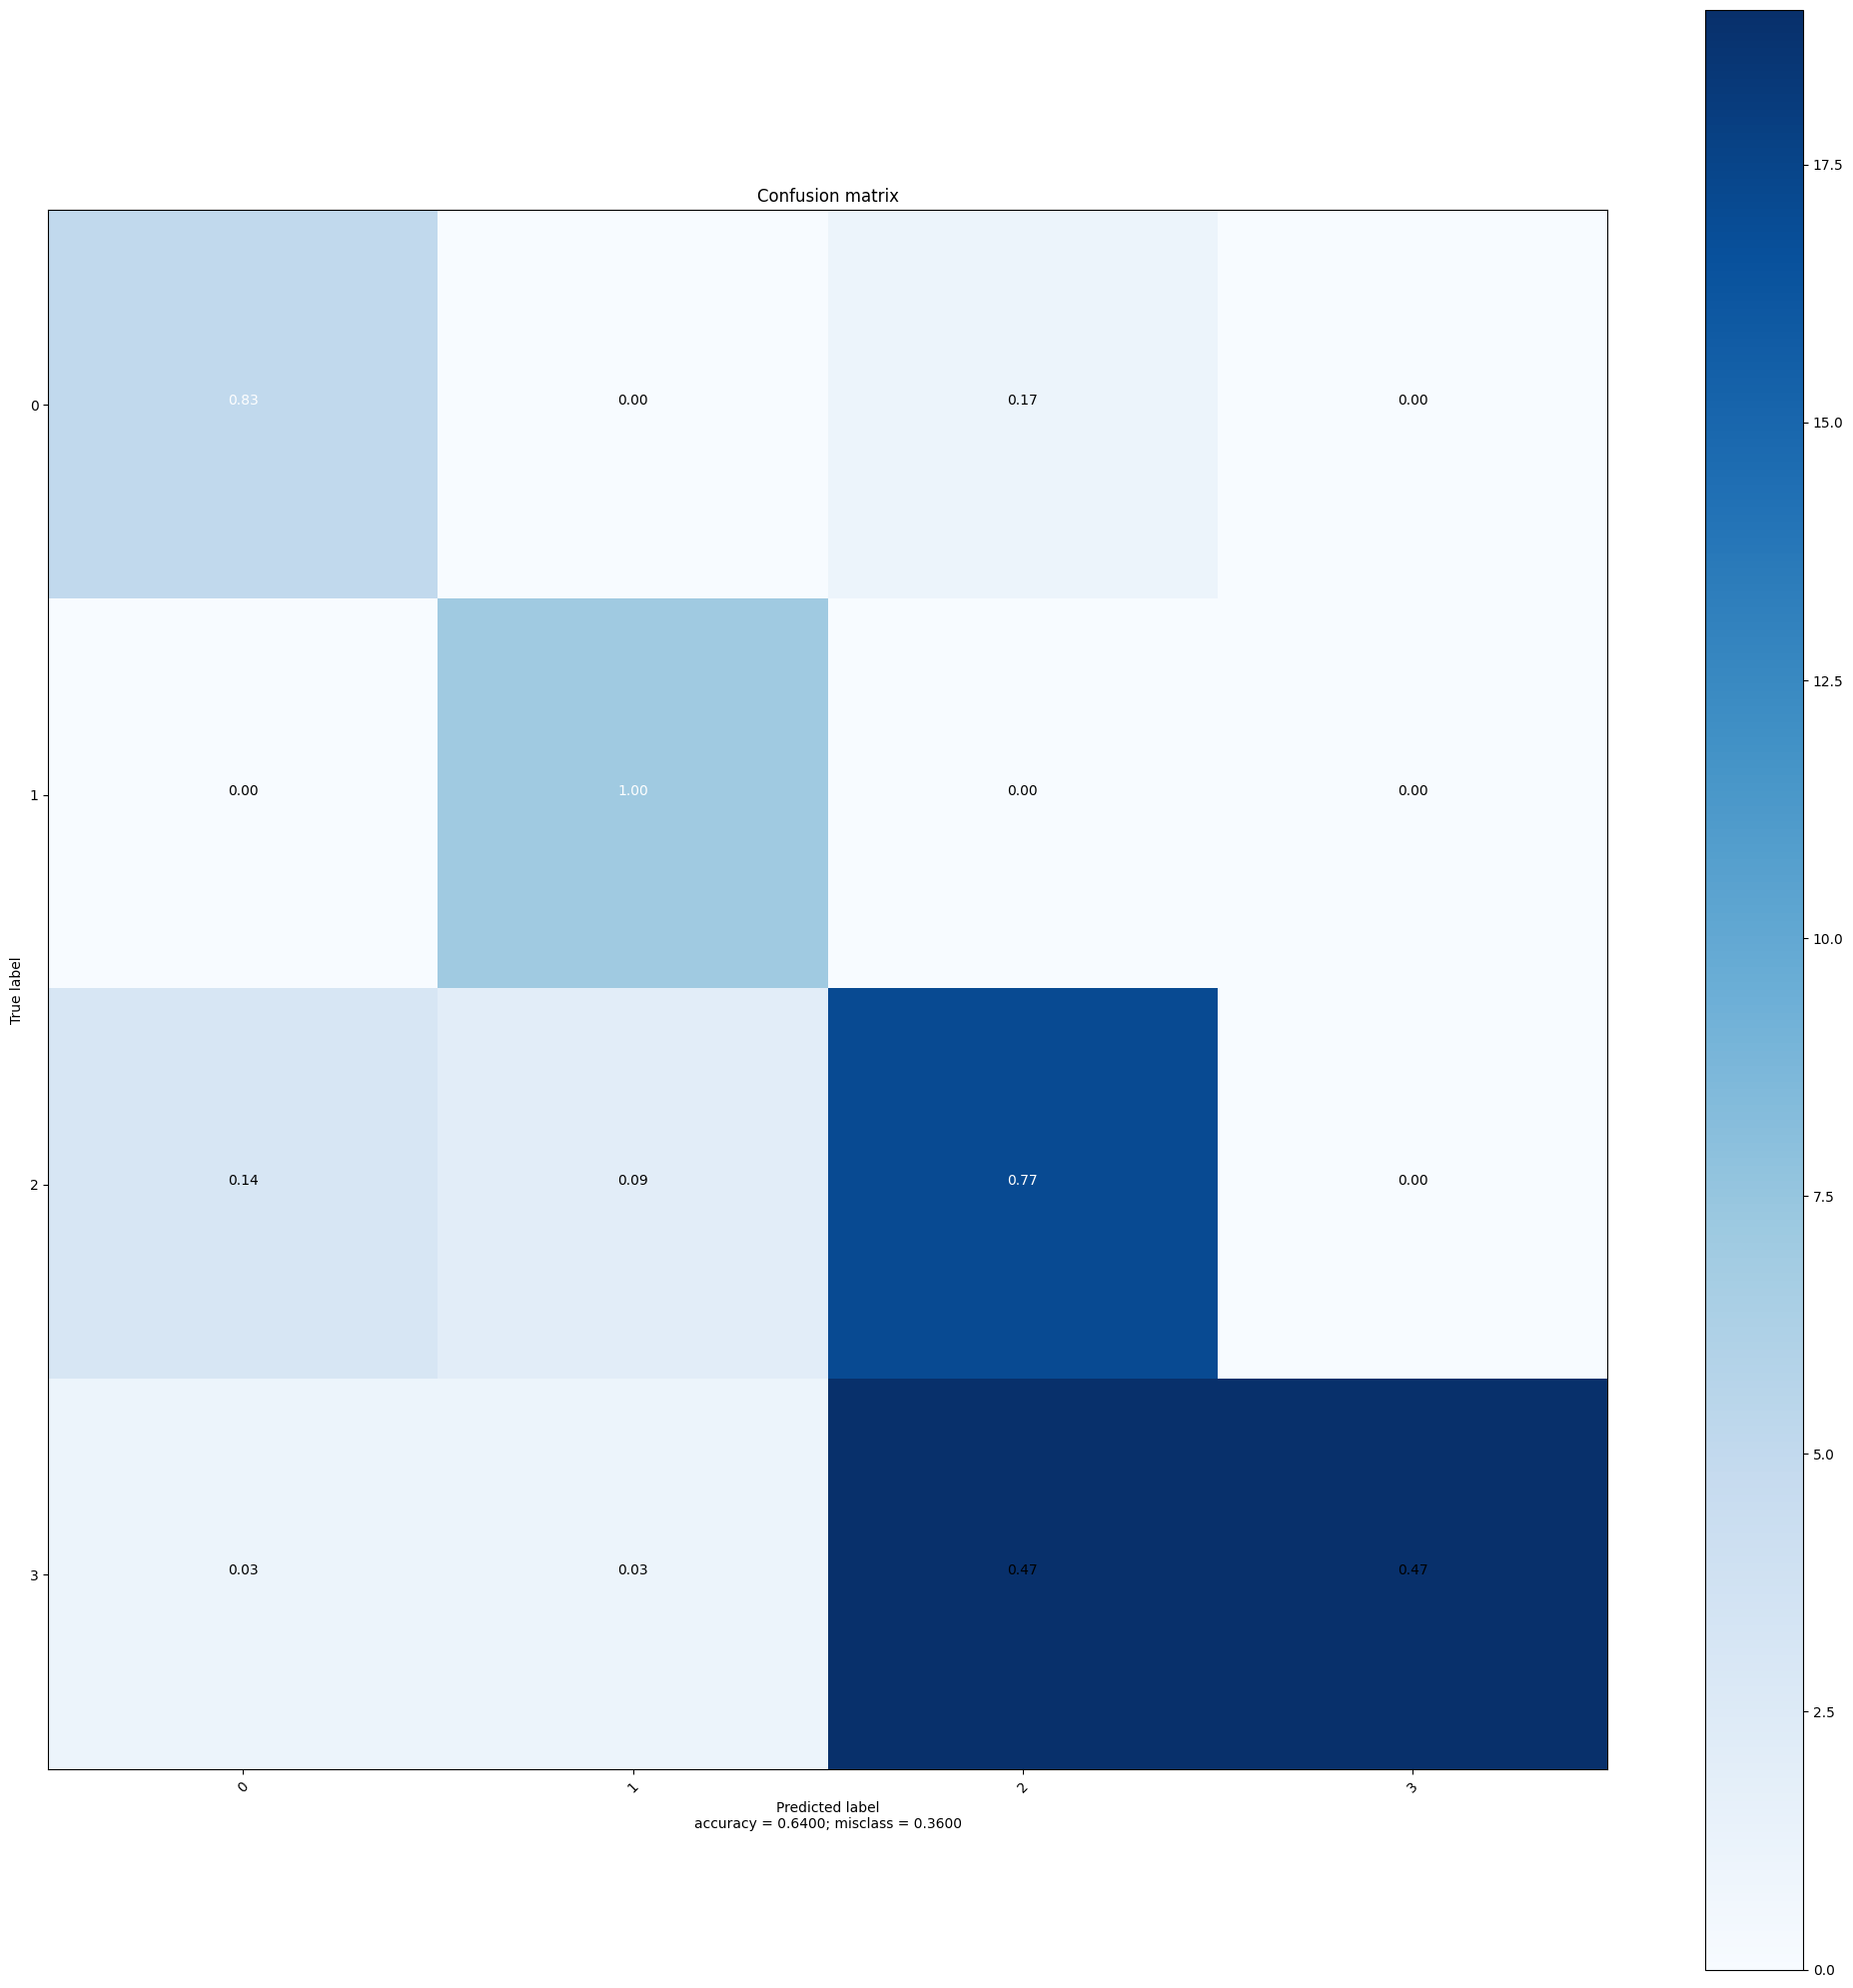

In [23]:
mean_, std_ = load_rgb_mean_std(f"{DATASET_DIR}/train")
# mean_, std_ = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
dl = Standard_DataLoader(f"{DATASET_DIR}/test", 32, False, 'test', mean_, std_, True)
produce_classification_reports(dl, DEVICE, model, OUTPUT_DIR, TEST_ID)